In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ttest_rel, wilcoxon
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV


In [2]:
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
# from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [3]:
df = pd.read_csv('cleaned_wait_times.csv')

In [4]:

df_model = df[(df["Metric"] == "50th Percentile") & (df['Reporting level'] == 'Provincial')].copy()

df_model['Naive'] = df_model.groupby(['Province', 'Indicator'])['Indicator result'].shift(1)

# Create lag and rolling features
df_model['Lag_1'] = df_model.groupby(['Province', 'Indicator'])['Indicator result'].shift(1)
df_model['Lag_2'] = df_model.groupby(['Province', 'Indicator'])['Indicator result'].shift(2)
df_model['Lag_3'] = df_model.groupby(['Province', 'Indicator'])['Indicator result'].shift(3)
df_model['Rolling_Mean_2'] = (
    df_model.groupby(['Province', 'Indicator'])['Indicator result']
    .transform(lambda x: x.shift(1).rolling(2).mean())
)

# Drop rows with NaN (from lags)
df_model.dropna(subset=['Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean_2'], inplace=True)

# Create feature matrix X and target y
X = df_model[["Province", "Indicator", "Data year", "Lag_1", "Lag_2", "Lag_3", "Rolling_Mean_2"]]
y = df_model["Indicator result"]

# Encode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = encoder.fit_transform(X[["Province", "Indicator"]])
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(["Province", "Indicator"]))
X_final = pd.concat([X_encoded_df, X[["Data year", "Lag_1", "Lag_2", "Lag_3", "Rolling_Mean_2"]].reset_index(drop=True)], axis=1)
X_final.index = df_model.index  # Ensure index alignment

In [5]:
# Chronological train/test split (time-aware)
train = df_model[df_model['Data year'] < 2020]
test = df_model[df_model['Data year'] >= 2020]

# Align indices with X_final
X_train = X_final.loc[train.index]
X_test = X_final.loc[test.index]
y_train = y.loc[train.index]
y_test = y.loc[test.index]
naive_train = train['Lag_1']
naive_test = test['Lag_1']


In [6]:
models = {
    'SVR':SVR(),
    'XGBRegressor':XGBRegressor(),
    'Ridge':Ridge(),
    'ElasticNet':ElasticNet(),
    # 'SGDRegressor':SGDRegressor(),
    'BayesianRidge':BayesianRidge(),
    'LinearRegression':LinearRegression(),
    'RandomForestRegressor':RandomForestRegressor(),
    'GradientBoostingRegressor':GradientBoostingRegressor()
}

In [7]:
model_results = []
model_names = []

for name, model in models.items():
  a = model.fit(X_train, y_train)
  y_pred = a.predict(X_test)
  score = mean_absolute_error(y_test, y_pred)
  model_results.append(score)
  model_names.append(name)

  # creating dataframe
  df_results = pd.DataFrame([model_names, model_results])
  df_results = df_results.T
  df_results.columns = ['Model', 'MAE']
  df_results = df_results.sort_values(by='MAE', ascending=True)

df_results


,Model,MAE
6,RandomForestRegressor,12.730826
7,GradientBoostingRegressor,13.320053
1,XGBRegressor,13.604153
5,LinearRegression,14.433765
2,Ridge,14.458732
3,ElasticNet,14.551673
4,BayesianRidge,14.820886
0,SVR,40.582291


In [8]:
# Using Random Forest Model without param tuning
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate model
mae_model= mean_absolute_error(y_test, y_pred)
rmse_model = np.sqrt(mean_squared_error(y_test, y_pred))

# Evaluate naive baseline
mae_naive = mean_absolute_error(y_test, naive_test)
rmse_naive = np.sqrt(mean_squared_error(y_test, naive_test))


df_results = pd.DataFrame({
    'Model': ['Naïve Baseline', 'Random Forest'],
    'MAE':   [mae_naive, mae_model],
    'RMSE':  [rmse_naive, rmse_model]
})

df_results

,Model,MAE,RMSE
0,Naïve Baseline,13.348161,29.438888
1,Random Forest,12.721534,29.284653


In [9]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predict on test set and calculate MAE
y_pred = model.predict(X_test)
mae_model = mean_absolute_error(y_test, y_pred)
print("MAE on test set:", mae_model)

Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 300}
MAE on test set: 12.179208566288617


In [10]:
# Apply best parameters from grid search to RandomForestRegressor and retrain
best_rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

# Evaluate model
mae_model = mean_absolute_error(y_test, y_pred)
rmse_model = np.sqrt(mean_squared_error(y_test, y_pred))

# Update results DataFrame
df_results = pd.DataFrame({
    'Model': ['Naïve Baseline', 'Random Forest (Tuned)'],
    'MAE':   [mae_naive, mae_model],
    'RMSE':  [rmse_naive, rmse_model]
})

df_results

,Model,MAE,RMSE
0,Naïve Baseline,13.348161,29.438888
1,Random Forest (Tuned),12.179209,28.545281


In [ ]:
# Compute absolute errors for both models
model_errors = np.abs(y_test - y_pred)
naive_errors = np.abs(y_test - naive_test)
improvement = naive_errors - model_errors

# PWilcoxon Signed-Rank Test
stat, p = wilcoxon(model_errors, naive_errors, alternative='less')  # 'less' means model < naive
print(f'Wilcoxon Signed-Rank Test, t-stat {stat}, p-value {p}')



Wilcoxon Signed-Rank Test, t-stat 75367.5, p-value 0.203781768079779


In [12]:
file_path = 'Complete_Estimated_Waiting_Cost_Per_Day_Canada.csv'
cost_data = pd.read_csv(file_path)
merged_df = pd.merge(df_model, cost_data, on=["Province", "Indicator"], how="left")
merged_df['Estimated Cost'] = merged_df['Indicator result'] * merged_df['Cost Per Day (CAD)']
merged_df['Estimated Cost Naive Base'] = merged_df['Naive'] * merged_df['Cost Per Day (CAD)']

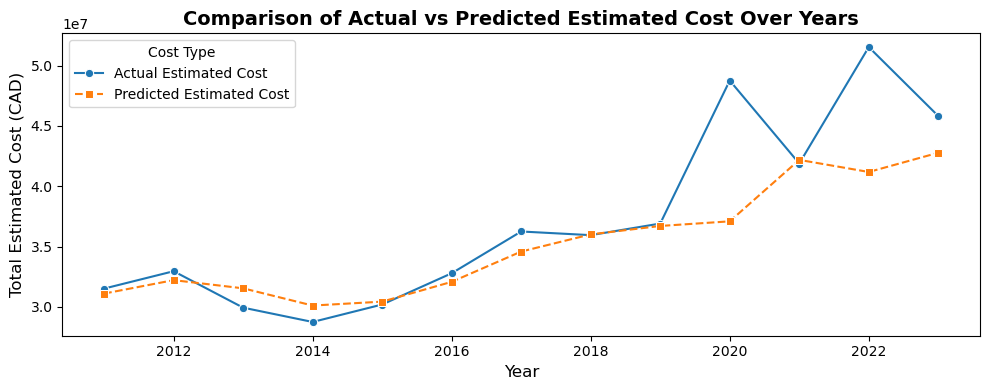

In [13]:
pred_df = merged_df.copy()

# Prepare predictors for cost estimation
# Make sure to include all lag and rolling features used in training
X_pred = pred_df[["Province", "Indicator", "Data year", "Lag_1", "Lag_2", "Lag_3", "Rolling_Mean_2"]]
X_encoded_pred = encoder.transform(X_pred[["Province", "Indicator"]])
X_encoded_df_pred = pd.DataFrame(X_encoded_pred, columns=encoder.get_feature_names_out(["Province", "Indicator"]))
X_final_pred = pd.concat([
	X_encoded_df_pred.reset_index(drop=True),
	X_pred[["Data year", "Lag_1", "Lag_2", "Lag_3", "Rolling_Mean_2"]].reset_index(drop=True)
], axis=1)

# Predict wait times using XGBoost model
predicted_wait_times = model.predict(X_final_pred)

# Estimate cost using predicted wait times
pred_df['Predicted Wait Time'] = predicted_wait_times
pred_df['Estimated Cost Predicted'] = pred_df['Predicted Wait Time'] * pred_df['Cost Per Day (CAD)']

# Aggregate cost by year
cost_summary = pred_df.groupby('Data year')[['Estimated Cost', 'Estimated Cost Predicted']].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 4))
sns.lineplot(data=cost_summary, x='Data year', y='Estimated Cost', label='Actual Estimated Cost', marker='o')
sns.lineplot(data=cost_summary, x='Data year', y='Estimated Cost Predicted', label='Predicted Estimated Cost', marker='s', linestyle='--')

# Labels and title with formatting
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Estimated Cost (CAD)', fontsize=12)
plt.title('Comparison of Actual vs Predicted Estimated Cost Over Years', fontsize=14, weight='bold')
plt.legend(title='Cost Type')
plt.tight_layout()
plt.show()

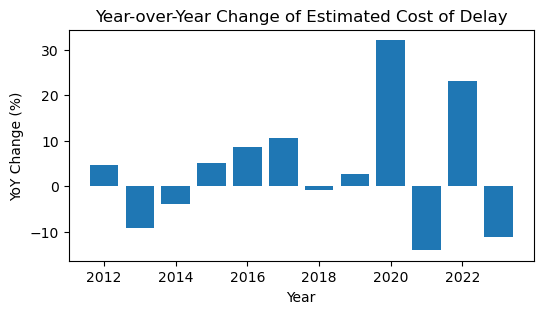

In [14]:
sum_cost = merged_df.groupby(['Data year'])[['Estimated Cost','Estimated Cost Naive Base']].sum()
sum_cost.replace(0,np.nan, inplace=True)
sum_cost['Change YoY'] = sum_cost['Estimated Cost'].pct_change()*100

fig = plt.figure(figsize=(6,3))
# plt.plot(sum_cost['Estimated Cost'], label = 'Actual Cost', linestyle='--')
plt.bar(x=sum_cost.index, height = sum_cost['Change YoY'])
plt.xlabel('Year')
plt.ylabel('YoY Change (%)')
plt.title("Year-over-Year Change of Estimated Cost of Delay")
plt.show()


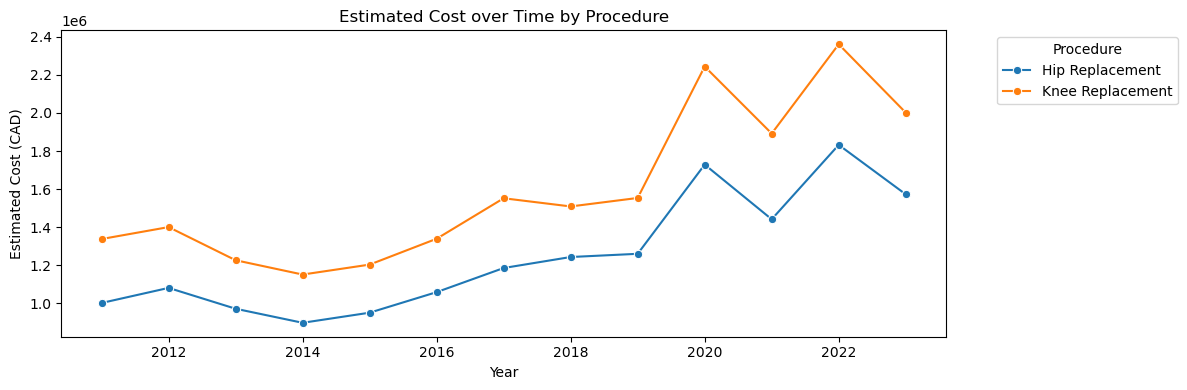

In [15]:
high_cost_df = merged_df[merged_df['Indicator'].isin(['Hip Replacement','Knee Replacement'])]

plt.figure(figsize=(12, 4))
sns.lineplot(data=high_cost_df, x='Data year', y='Estimated Cost', hue='Indicator', marker='o',errorbar=None)

plt.title("Estimated Cost over Time by Procedure")
plt.xlabel("Year")
plt.ylabel("Estimated Cost (CAD)")
plt.legend(title='Procedure', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


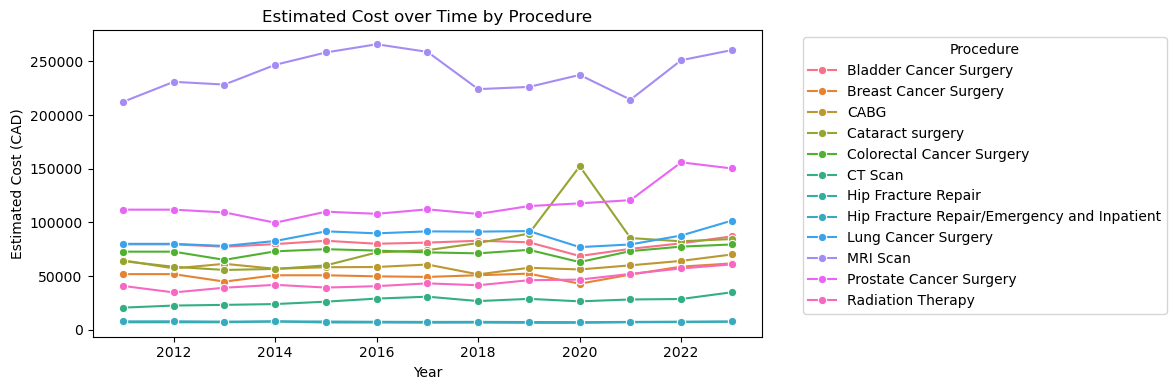

In [16]:
low_cost_df = merged_df[~merged_df['Indicator'].isin(['Hip Replacement','Knee Replacement'])]

plt.figure(figsize=(12, 4))
sns.lineplot(data=low_cost_df, x='Data year', y='Estimated Cost', hue='Indicator', marker='o',errorbar=None)

plt.title("Estimated Cost over Time by Procedure")
plt.xlabel("Year")
plt.ylabel("Estimated Cost (CAD)")
plt.legend(title='Procedure', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

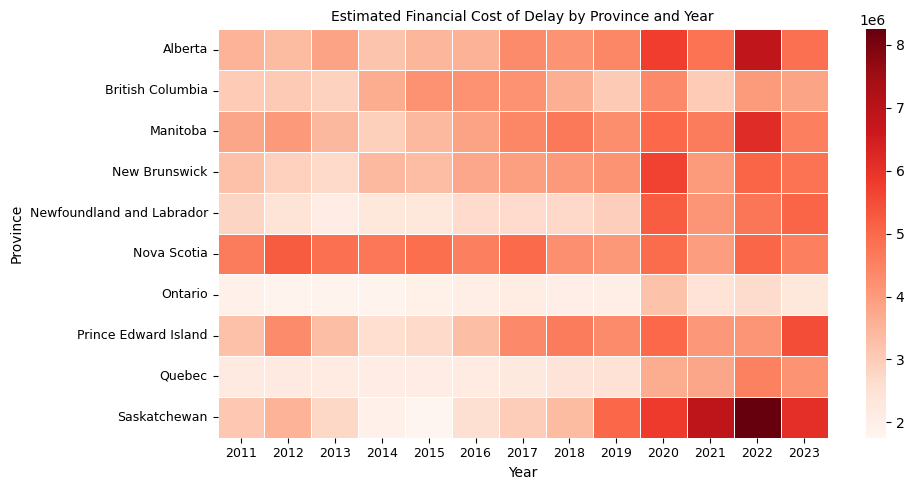

In [17]:
heatmap_df = merged_df[['Data year', 'Province', 'Estimated Cost']]


heatmap_pivot = heatmap_df.pivot_table(
    index='Province',
    columns='Data year',
    values='Estimated Cost',
    aggfunc='sum'
)

plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_pivot, cmap='Reds', annot=False, linewidths=0.5)

plt.title("Estimated Financial Cost of Delay by Province and Year", fontsize=10)
plt.xlabel("Year", fontsize=10)
plt.ylabel("Province", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

<Axes: xlabel='Estimated Cost', ylabel='Count'>

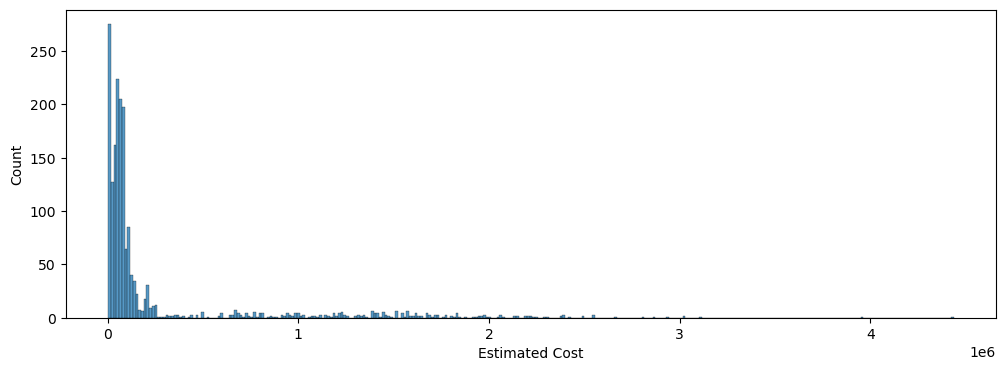

In [18]:
plt.figure(figsize=(12,4))
sns.histplot(data=merged_df['Estimated Cost'])


In [19]:
merged_df['Estimated Cost'].describe().round(2).reset_index()

,index,Estimated Cost
0,count,1820.00
1,mean,265501.66
2,std,529484.15
3,min,2803.50
4,25%,36540.00
5,50%,70000.00
6,75%,124410.00
7,max,4436500.00


In [20]:
# Project wait times for years after 2023 (e.g., 2024, 2025, 2026)
future_years = [2024, 2025, 2026]
provinces = df_model['Province'].unique()
indicators = df_model['Indicator'].unique()

# Start with the last available data for each Province/Indicator
last_rows = df_model.sort_values('Data year').groupby(['Province', 'Indicator']).tail(3)

future_preds = []

for province in provinces:
    for indicator in indicators:
        # Get the last 3 years of data for this group
        group = last_rows[(last_rows['Province'] == province) & (last_rows['Indicator'] == indicator)].sort_values('Data year')
        if group.shape[0] < 3:
            continue  # Not enough history
        lag_1 = group.iloc[-1]['Indicator result']
        lag_2 = group.iloc[-2]['Indicator result']
        lag_3 = group.iloc[-3]['Indicator result']
        rolling_2 = np.mean([lag_1, lag_2])
        last_year = group.iloc[-1]['Data year']
        for year in future_years:
            # Prepare features for prediction
            X_pred = pd.DataFrame({
                'Province': [province],
                'Indicator': [indicator],
                'Data year': [year],
                'Lag_1': [lag_1],
                'Lag_2': [lag_2],
                'Lag_3': [lag_3],
                'Rolling_Mean_2': [rolling_2]
            })
            X_encoded_pred = encoder.transform(X_pred[['Province', 'Indicator']])
            X_encoded_df_pred = pd.DataFrame(X_encoded_pred, columns=encoder.get_feature_names_out(['Province', 'Indicator']))
            X_final_pred = pd.concat([
                X_encoded_df_pred.reset_index(drop=True),
                X_pred[['Data year', 'Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean_2']].reset_index(drop=True)
            ], axis=1)
            # Predict
            pred = model.predict(X_final_pred)[0]
            future_preds.append({
                'Province': province,
                'Indicator': indicator,
                'Data year': year,
                'Predicted Wait Time': pred
            })
            # Update lags for next year
            lag_3 = lag_2
            lag_2 = lag_1
            lag_1 = pred
            rolling_2 = np.mean([lag_1, lag_2])

future_df = pd.DataFrame(future_preds)

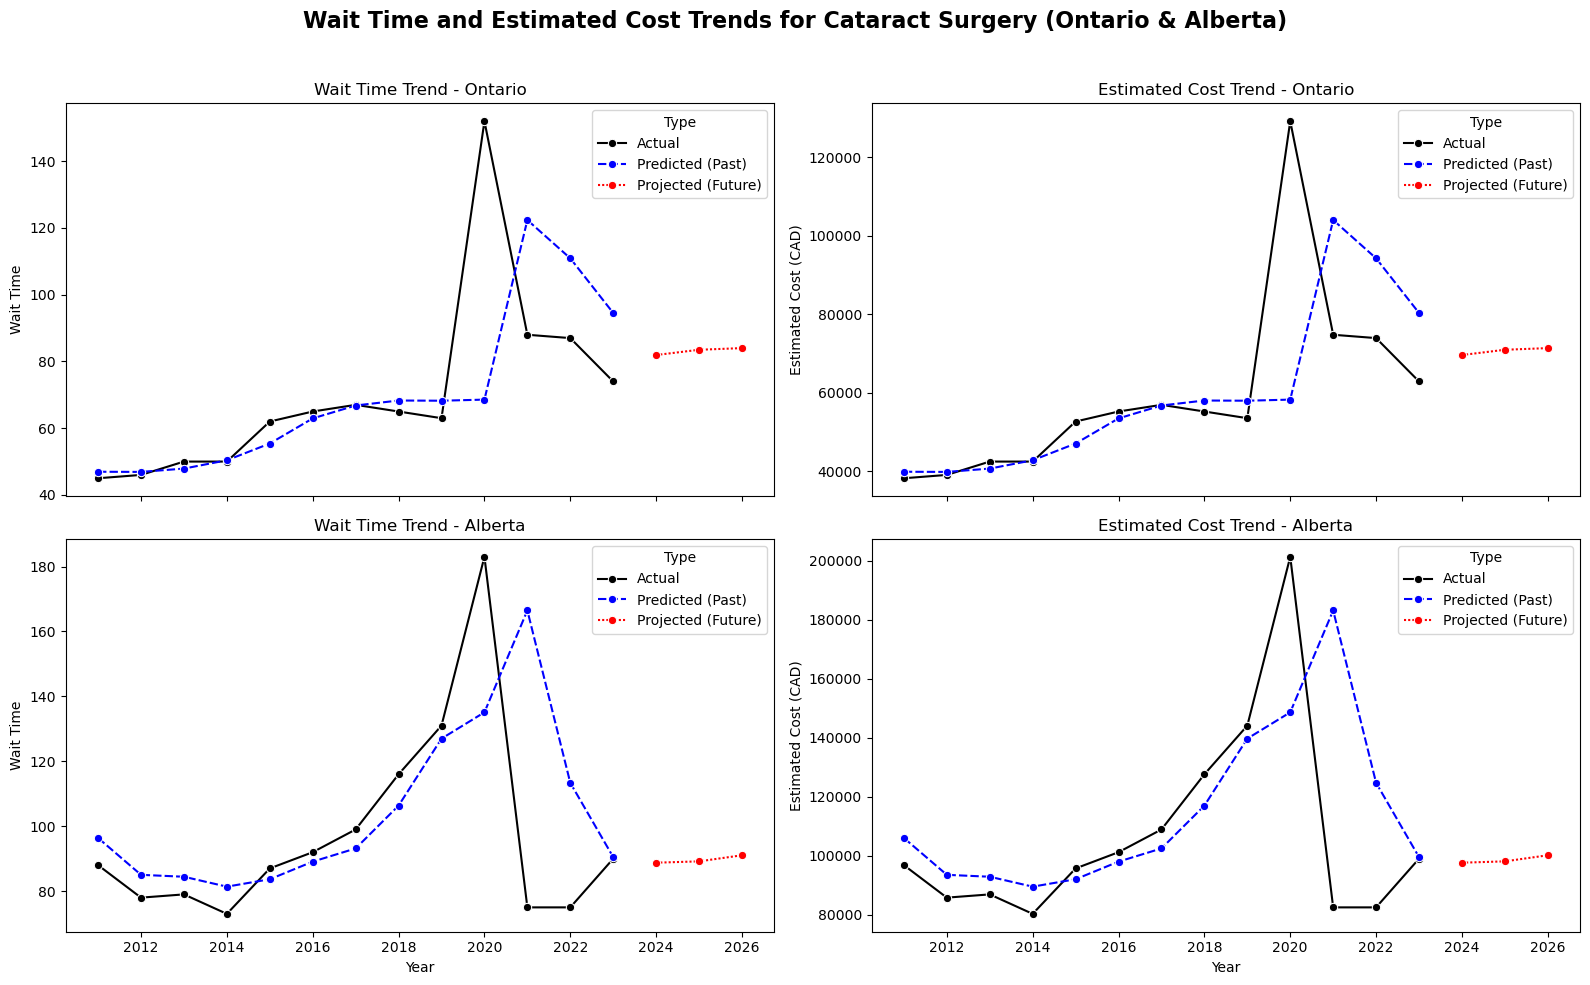

In [28]:
# Plot wait time and cost trends for Cataract surgery in Ontario & Alberta (4 subplots)
provinces = ['Ontario', 'Alberta']
indicator = 'Cataract surgery'

fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
plt.subplots_adjust(hspace=0.3, wspace=0.2)

for i, province in enumerate(provinces):
    # --- Wait Time ---
    # Actual
    wait_actual = merged_df[
        (merged_df['Province'] == province) &
        (merged_df['Indicator'] == indicator)
    ][['Data year', 'Indicator result']].copy()
    wait_actual['Type'] = 'Actual'
    # Predicted (Past)
    wait_pred = pred_df[
        (pred_df['Province'] == province) &
        (pred_df['Indicator'] == indicator)
    ][['Data year', 'Predicted Wait Time']].copy()
    wait_pred = wait_pred.rename(columns={'Predicted Wait Time': 'Indicator result'})
    wait_pred['Type'] = 'Predicted (Past)'
    # Projected (Future)
    wait_proj = future_df[
        (future_df['Province'] == province) &
        (future_df['Indicator'] == indicator)
    ][['Data year', 'Predicted Wait Time']].copy()
    wait_proj = wait_proj.rename(columns={'Predicted Wait Time': 'Indicator result'})
    wait_proj['Type'] = 'Projected (Future)'
    wait_all = pd.concat([wait_actual, wait_pred, wait_proj], ignore_index=True)
    ax = axes[i, 0]
    sns.lineplot(
        data=wait_all,
        x='Data year',
        y='Indicator result',
        hue='Type',
        style='Type',
        marker='o',
        palette={'Actual': 'black', 'Predicted (Past)': 'blue', 'Projected (Future)': 'red'},
        ax=ax
    )
    ax.set_title(f'Wait Time Trend - {province}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Wait Time')
    ax.legend(title='Type')

    # --- Cost ---
    # Actual
    cost_actual = merged_df[
        (merged_df['Province'] == province) &
        (merged_df['Indicator'] == indicator)
    ][['Data year', 'Estimated Cost']].copy()
    cost_actual['Type'] = 'Actual'
    # Predicted (Past)
    cost_pred_past = pred_df[
        (pred_df['Province'] == province) &
        (pred_df['Indicator'] == indicator)
    ][['Data year', 'Estimated Cost Predicted']].copy()
    cost_pred_past = cost_pred_past.rename(columns={'Estimated Cost Predicted': 'Estimated Cost'})
    cost_pred_past['Type'] = 'Predicted (Past)'
    # Projected (Future)
    future_cost = future_df[
        (future_df['Province'] == province) &
        (future_df['Indicator'] == indicator)
    ].merge(
        cost_data[['Province', 'Indicator', 'Cost Per Day (CAD)']],
        on=['Province', 'Indicator'],
        how='left'
    )
    future_cost['Estimated Cost'] = future_cost['Predicted Wait Time'] * future_cost['Cost Per Day (CAD)']
    future_cost = future_cost[['Data year', 'Estimated Cost']]
    future_cost['Type'] = 'Projected (Future)'
    cost_all = pd.concat([cost_actual, cost_pred_past, future_cost], ignore_index=True)
    ax = axes[i, 1]
    sns.lineplot(
        data=cost_all,
        x='Data year',
        y='Estimated Cost',
        hue='Type',
        style='Type',
        marker='o',
        palette={'Actual': 'black', 'Predicted (Past)': 'blue', 'Projected (Future)': 'red'},
        ax=ax
    )
    ax.set_title(f'Estimated Cost Trend - {province}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Estimated Cost (CAD)')
    ax.legend(title='Type')

axes[0, 0].set_ylabel('Wait Time')
axes[1, 0].set_ylabel('Wait Time')
axes[0, 1].set_ylabel('Estimated Cost (CAD)')
axes[1, 1].set_ylabel('Estimated Cost (CAD)')
plt.suptitle('Wait Time and Estimated Cost Trends for Cataract Surgery (Ontario & Alberta)', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()